# Chapter 3: Modelling and Evaluation - Analyse

In [29]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

from dmba import classificationSummary

#  Lineare Regression
## Einfache Lineare Regression

     Adj Close  FEDFUNDS
0    16.750000      0.12
1    16.855000      0.12
2    18.010000      0.12
3    17.940001      0.11
4    18.370001      0.13
..         ...       ...
158  68.477997      4.10
159  71.818001      4.33
160  72.244003      4.57
161  72.377998      4.65
162  72.566002      4.83

[163 rows x 2 columns]
Intercept: -0.485
Coefficient Exposure: 0.029


C:\Users\hoang\Desktop\ss_2023_bkds_stonk\venv\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


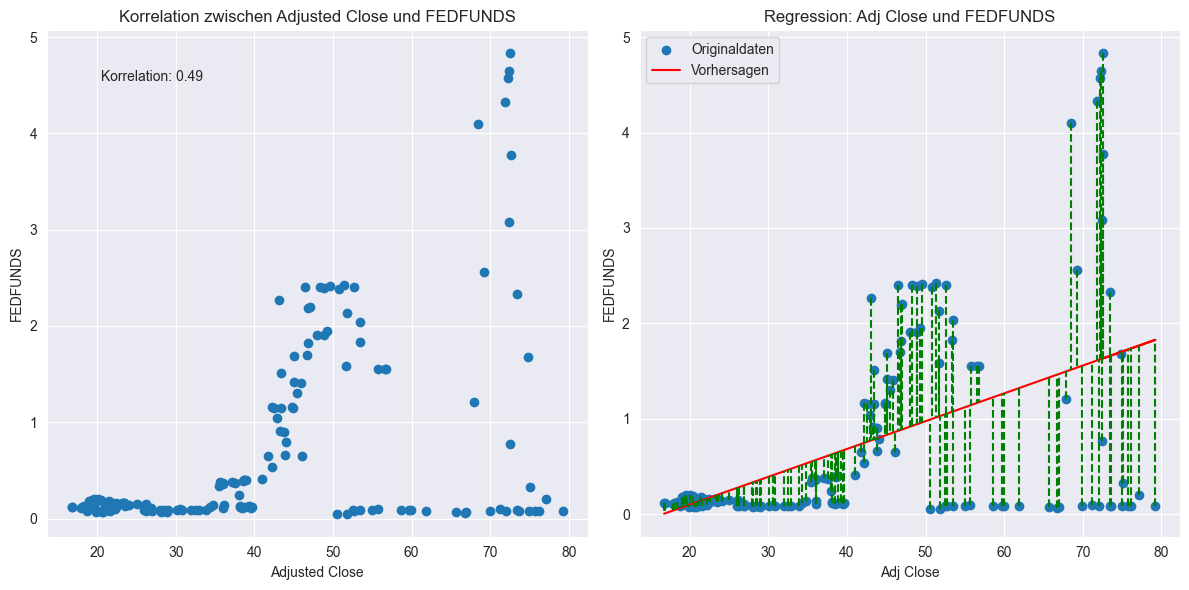

In [30]:
# Daten einlesen
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

# Daten filtern und kombinieren
etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen
# reset_index()-Funktion setzt Index des Datenrahmens zurücksetzt
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)

# print(len(etf_filtered))
# print(len(fed_funds_filtered))
# # Überprüfen der Datenlängen
# if len(etf_filtered) != len(fed_funds_filtered):
#     raise ValueError("Die Datenlängen stimmen nicht überein.")

# Korrelation berechnen
correlation = etf_fed_funds_combined_data.corr().iloc[0, 1]
# print(correlation)
etf_fed_funds_combined_data.dropna(inplace=True)
#etf_fed_funds_combined_data.fillna(etf_fed_funds_combined_data.mean(), inplace=True)
etf_fed_funds_combined_data.interpolate(inplace=True)

print(etf_fed_funds_combined_data)

#----------------------------------------------------------------------------------------

model = LinearRegression()

# Reshape der Eingabe in die 2D-Array-Form
X = etf_fed_funds_combined_data['Adj Close'].values.reshape(-1, 1)
y = etf_fed_funds_combined_data['FEDFUNDS'].values.reshape(-1, 1)
model.fit(X, y)

fitted = model.predict(X)
residuals = y - fitted

print(f'Intercept: {model.intercept_[0]:.3f}')
print(f'Coefficient Exposure: {model.coef_[0][0]:.3f}')

# Vorhersagen und Residuen berechnen
fitted = model.predict(X)
residuals = y - fitted

# Figure und Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot der Korrelation
ax1.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'])
ax1.set_xlabel('Adjusted Close')
ax1.set_ylabel('FEDFUNDS')
ax1.set_title('Korrelation zwischen Adjusted Close und FEDFUNDS')
ax1.text(0.1, 0.9, f'Korrelation: {correlation:.2f}', transform=ax1.transAxes)

# Scatterplot und Linienplot der Regression
ax2.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], label='Originaldaten')
ax2.plot(etf_fed_funds_combined_data['Adj Close'], fitted, color='red', label='Vorhersagen')

# Residuenlinien zeichnen
for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted):
    ax2.plot([x, x], [y_actual, y_fitted], '--', color='green')

ax2.set_xlabel('Adj Close')
ax2.set_ylabel('FEDFUNDS')
ax2.set_title('Regression: Adj Close und FEDFUNDS')
ax2.legend()

# Diagramme anzeigen
plt.tight_layout()
plt.show()


## Multiple Lineare Regression (30, 31, 15)

In [31]:
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close', 'Volume']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen und fehlende Werte interpolieren
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)
etf_fed_funds_combined_data.interpolate(inplace=True)

In [32]:
# Daten aus der CSV-Datei laden
leitzins_df = pd.read_csv('data/leitzins Europa.csv')

# Spalten "Obs. Status" und "Obs. Comment" entfernen
leitzins_df = leitzins_df.drop(['obs. status', 'obs. comment'], axis=1)

# Umwandeln des Datums in das Datumsformat
leitzins_df['Date'] = pd.to_datetime(leitzins_df['Date'])

# Filtern der Daten nach dem gewünschten Zeitraum
leitzins_filtered = leitzins_df[(leitzins_df['Date'] >= '1999-01-01') & (leitzins_df['Date'] <= '2023-04-22')]

# Extrahieren von Monat und Jahr aus dem Datum
leitzins_filtered['Monat'] = leitzins_filtered['Date'].dt.month
leitzins_filtered['Jahr'] = leitzins_filtered['Date'].dt.year

# Gruppieren nach Jahr und Monat und Berechnung des Durchschnitts
monatliche_leitzins_df = leitzins_filtered.groupby(['Jahr', 'Monat']).mean()

# Speichern der monatlichen Leitzinswerte in eine neue CSV-Datei
monatliche_leitzins_df.to_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv', index=False)

In [33]:
# CSV-Datei einlesen
fed_funds_customer_monthly = pd.read_csv('data/Leitzins_USA_FED_Kunden.csv')

# Spalte 'DATE' in ein DateTime-Format konvertieren
fed_funds_customer_monthly['DATE'] = pd.to_datetime(fed_funds_customer_monthly['DATE'])

# DataFrame-Index auf 'DATE' setzen
fed_funds_customer_monthly.set_index('DATE', inplace=True)

# Datenreihe resamplen und fehlende Monate auffüllen
fed_funds_customer_monthly = fed_funds_customer_monthly.resample('MS').ffill()

# DataFrame-Index zurücksetzen
fed_funds_customer_monthly = fed_funds_customer_monthly.reset_index()

# CSV-Datei mit aufgefüllten Monaten speichern
fed_funds_customer_monthly.to_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv', index=False)

In [34]:
# Auslesen der einzelnen Daten in einer Tabelle

etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds_banks_monthly = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')
eu_funds_monthly = pd.read_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv')
fed_funds_customer_monthly_extends = pd.read_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv')
eur_usd_exch = pd.read_csv('data/generatedDatasets/combined_etf_currency_data.csv')


etf_monthly_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-04-01'), ['Date', 'Adj Close' , 'Volume']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

eu_funds_monthly_filtered = eu_funds_monthly.loc[(eu_funds_monthly['Date'] >= '2009-10-01') & (eu_funds_monthly['Date'] <= '2023-04-01'), ['Percent per annum']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

fed_funds_customer_monthly_extends_filtered = fed_funds_customer_monthly_extends.loc[(fed_funds_customer_monthly_extends['DATE'] >= '2009-10-01') & (fed_funds_customer_monthly_extends['DATE'] <= '2023-04-01'), ['PRIME']]

# eur_usd_exch_filtered = eur_usd_exch[(eur_usd_exch['Date'] >= '2009-10-01') & (eur_usd_exch['Date'] <= '2023-04-01'), ['Date','USD_EUR_Exch_Rate']]



pre_regression_combined_data = pd.concat([etf_monthly_filtered.reset_index(drop=True), eu_funds_monthly_filtered.reset_index(drop=True), fed_funds_banks_monthly_filtered.reset_index(drop=True), fed_funds_customer_monthly_extends_filtered.reset_index(drop=True)], axis=1)

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'Percent per annum': 'ezb_funds'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'FEDFUNDS': 'fed_funds_for_banks'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'PRIME': 'fed_funds_for_customer'})

print(pre_regression_combined_data)


           Date  Adj Close      Volume  ezb_funds  fed_funds_for_banks  \
0    2009-10-01  16.750000       850.0   1.000000                 0.12   
1    2009-11-01  16.855000      1066.0   1.000000                 0.12   
2    2009-12-01  18.010000      1117.0   1.000000                 0.12   
3    2010-01-01  17.940001      2789.0   1.000000                 0.11   
4    2010-02-01  18.370001     96452.0   1.000000                 0.13   
..          ...        ...         ...        ...                  ...   
158  2022-12-01  68.477997   6728267.0   2.177419                 4.10   
159  2023-01-01  71.818001   6731261.0   2.500000                 4.33   
160  2023-02-01  72.244003   5824871.0   2.875000                 4.57   
161  2023-03-01  72.377998  10135602.0   3.161290                 4.65   
162  2023-04-01  72.566002   6208642.0        NaN                 4.83   

     fed_funds_for_customer  
0                      3.25  
1                      3.25  
2                    

In [35]:
subset = ['Adj Close', 'ezb_funds', 'fed_funds_for_banks', ]

print(pre_regression_combined_data[subset].head())

pre_regression_combined_data.to_csv('data/generatedDatasets/multiple_regression_combined_data.csv', index=False)


   Adj Close  ezb_funds  fed_funds_for_banks
0  16.750000        1.0                 0.12
1  16.855000        1.0                 0.12
2  18.010000        1.0                 0.12
3  17.940001        1.0                 0.11
4  18.370001        1.0                 0.13


In [36]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer']
outcome = 'Adj Close'

adjClose_etf_lm = LinearRegression()
adjClose_etf_lm.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome])

print(f'Intercept: {adjClose_etf_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_lm.coef_):
    print(f' {name}: {coef}')


Intercept: 28.944
Coefficients:
 ezb_funds: -12.76264906264126
 fed_funds_for_banks: 7.228215416972676
 fed_funds_for_customer: 3.248414184528484


### Konfidenzintervalle der MLR-Koeffizienten (17)

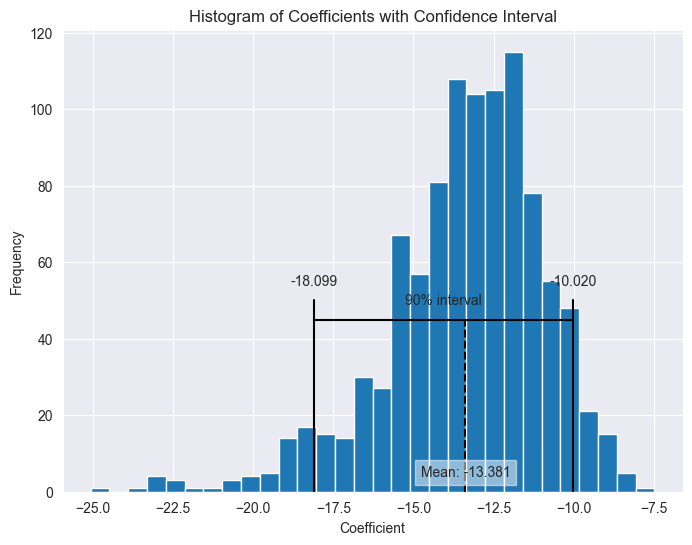

In [37]:
# Daten einlesen und fehlende Werte entfernen
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer']
outcome = 'Adj Close'

adjClose_etf_lm = LinearRegression()
adjClose_etf_lm.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome])

# Bootstrap-Funktion für die Koeffizienten Berechnung
def bootstrap_coefficients(data, predictors, outcome, num_bootstrap_samples=1000):
    coefficients = []
    n = data.shape[0]
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = data.sample(n, replace=True)
        lm = LinearRegression()
        lm.fit(bootstrap_sample[predictors], bootstrap_sample[outcome])
        coefficients.append(lm.coef_)
    return np.array(coefficients)

# Koeffizienten mit der Bootstrap-Methode berechnen
bootstrap_coefficients = bootstrap_coefficients(multiple_regression_combined_data, predictors, outcome)

# Konfidenzintervall berechnen
# erste Koeffizient
results = pd.Series(bootstrap_coefficients[:, 0])
confidence_interval = list(results.quantile([0.05, 0.95]))

# Diagramm erstellen
ax = results.plot.hist(bins=30, figsize=(8, 6))
ax.plot(confidence_interval, [45, 45], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 50], color='black')
    ax.text(x, 55, f'{x:.3f}',
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 50, '90% interval',
        horizontalalignment='center', verticalalignment='center')

mean_of_coefficients = results.mean()
ax.plot([mean_of_coefficients, mean_of_coefficients], [0, 45], color='black', linestyle='--')
ax.text(mean_of_coefficients, 5, f'Mean: {mean_of_coefficients:.3f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
plt.xlabel('Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Coefficients with Confidence Interval')

plt.show()


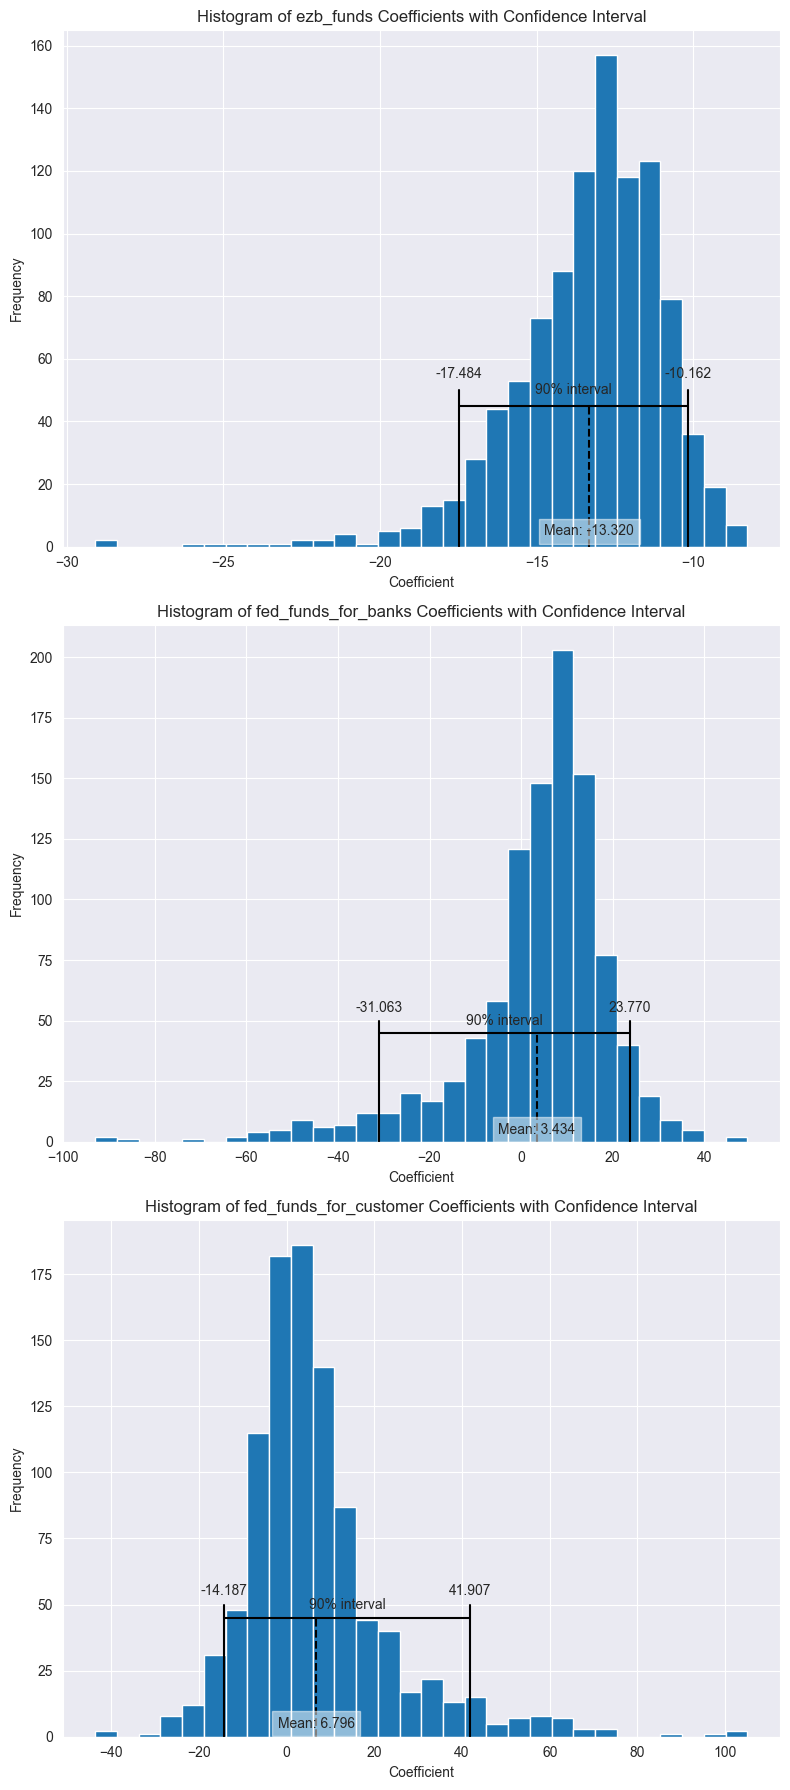

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Daten einlesen und fehlende Werte entfernen
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer']
outcome = 'Adj Close'

adjClose_etf_lm = LinearRegression()
adjClose_etf_lm.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome])

# Bootstrap-Funktion für die Koeffizientenberechnung
def bootstrap_coefficients(data, predictors, outcome, num_bootstrap_samples=1000):
    coefficients = []
    n = data.shape[0]
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = data.sample(n, replace=True)
        lm = LinearRegression()
        lm.fit(bootstrap_sample[predictors], bootstrap_sample[outcome])
        coefficients.append(lm.coef_)
    return np.array(coefficients)

# Koeffizienten mit der Bootstrap-Methode berechnen
bootstrap_coefficients = bootstrap_coefficients(multiple_regression_combined_data, predictors, outcome)

# Konfidenzintervall berechnen und Diagramme erstellen
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

for i, predictor in enumerate(predictors):
    results = pd.Series(bootstrap_coefficients[:, i])
    confidence_interval = list(results.quantile([0.05, 0.95]))


    ax = axs[i]
    ax.hist(results, bins=30)
    for x in confidence_interval:
        ax.plot([x, x], [0, 50], color='black')
        ax.text(x, 55, f'{x:.3f}',
                horizontalalignment='center', verticalalignment='center')
    ax.text(sum(confidence_interval) / 2, 50, '90% interval',
            horizontalalignment='center', verticalalignment='center')

    mean_of_coefficients = results.mean()
    ax.plot(confidence_interval, [45, 45], color='black')

    ax.plot([mean_of_coefficients, mean_of_coefficients], [0, 45], color='black', linestyle='--')
    ax.text(mean_of_coefficients, 5, f'Mean: {mean_of_coefficients:.3f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')

    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {predictor} Coefficients with Confidence Interval')

plt.tight_layout()
plt.show()


## Gewichtete Multiple Lineare Regression (16)

In [39]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

# Definiere die Prädiktoren und das Ziel
predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer']
outcome = 'Adj Close'

# Gewichtung basierend auf dem Volumen
weights = multiple_regression_combined_data['Volume']

# Initialisiere das lineare Regressionsmodell mit gewichteten Daten
adjClose_etf_wt = LinearRegression()
adjClose_etf_wt.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome], sample_weight=weights)

# Zeige die Ergebnisse an
print('Berechnung basierend auf der Gewichtung des Volumens')
print(f'Intercept: {adjClose_etf_wt.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_wt.coef_):
    print(f' {name}: {coef}')



Berechnung basierend auf der Gewichtung des Volumens
Intercept: 87.835
Coefficients:
 ezb_funds: 6.512985853309622
 fed_funds_for_banks: 8.114393693831994
 fed_funds_for_customer: -9.556114176848865


In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Daten aus der CSV-Datei lesen
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

# Datum in Spalte "Date" in ein Datumsobjekt konvertieren
multiple_regression_combined_data['Date'] = pd.to_datetime(multiple_regression_combined_data['Date'])

# Berechnung der monatlichen Rendite
multiple_regression_combined_data['Monthly Return'] = (multiple_regression_combined_data['Adj Close'] - multiple_regression_combined_data['Adj Close'].shift(1)) / multiple_regression_combined_data['Adj Close'].shift(1) * 100

# NaN-Werte in der Spalte "Monthly Return" mit 0 ersetzen
multiple_regression_combined_data['Monthly Return'].fillna(0, inplace=True)

multiple_regression_combined_data.to_csv('data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

# Definiere die Prädiktoren und das Ziel
predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer']
outcome = 'Monthly Return'

# Trainingsdaten: Daten bis zum maximalen Datum
# Filterung der Daten nur Zeilen deren Datum kleiner oder gleich dem maximalen Datum in der Spalte "Date" --> Erhaltung von Trainingsdaten, die bis zum maximalen Datum reichen
train_data = multiple_regression_combined_data[multiple_regression_combined_data['Date'] <= multiple_regression_combined_data['Date'].max()]

# Modell initialisieren und trainieren
# train_data[predictors] sind die unabhängigen Variablen (Prädiktoren)
# train_data[outcome] ist die abhängige Variable (Ziel).
monthy_return_wl = LinearRegression()
monthy_return_wl.fit(train_data[predictors], train_data[outcome])

# Vorhersage für den 1. August 2023 treffen
# [pd.to_datetime('2023-08-01'), 0, 0, 0]], columns=['Date'] + predictors ist notwendig um die Datenstruktur für das trainierten Modell zu verwenden
# Wert 0 wird für alle Prädiktoren (ezb_funds, fed_funds_for_banks, fed_funds_for_customer) verwendet, da es sich um eine Vorhersage handelt und keine tatsächlichen Werte für diese Variablen vorliegen
prediction_data = pd.DataFrame([[pd.to_datetime('2023-08-01'), 0, 0, 0]], columns=['Date'] + predictors)
prediction = monthy_return_wl.predict(prediction_data[predictors])

# Intercept und Koeffizienten ausgeben
print('Berechnung basierend auf der Gewichtung des historischen Zeitrahmens:')
print('Intercept:', monthy_return_wl.intercept_)
print('Coefficients:')
for name, coef in zip(predictors, monthy_return_wl.coef_):
    print(f' {name}: {coef}')

print()
print('Vorhersage für den 01.08.2023:')
print(f'Monatliche Rendite: {prediction[0]:.2f}')


Berechnung basierend auf der Gewichtung des historischen Zeitrahmens:
Intercept: 5.7913023987362715
Coefficients:
 ezb_funds: -0.104806680694586
 fed_funds_for_banks: 1.0925324558159264
 fed_funds_for_customer: -1.4527754089689695

Vorhersage für den 01.08.2023:
Monatliche Rendite: 5.79


In [41]:
pd.concat([
    pd.DataFrame({
        'predictor': ['intercept'],
        'adj_close_lm': adjClose_etf_lm.intercept_,
        'adj_close_wt': adjClose_etf_wt.intercept_,
        'monthy_return_wl': monthy_return_wl.intercept_
    }),
    pd.DataFrame({
        'predictor': predictors,
        'adj_close_lm': adjClose_etf_lm.coef_,
        'adj_close_wt': adjClose_etf_wt.coef_,
        'monthy_return_wl': monthy_return_wl.coef_
    }),

])

,predictor,adj_close_lm,adj_close_wt,monthy_return_wl
0,intercept,28.944295,87.834845,5.791302
0,ezb_funds,-12.762649,6.512986,-0.104807
1,fed_funds_for_banks,7.228215,8.114394,1.092532
2,fed_funds_for_customer,3.248414,-9.556114,-1.452775


# Klassifikation
## Kernidee der Klassifikation
Das Ziel der Klassifikation in Data Science ist es, Muster und Zusammenhänge in Daten zu identifizieren, um Vorhersagen oder Klassifikationen für neue, unbekannte Datenpunkte zu treffen. Die Klassifikation ist ein überwachtes Lernverfahren, bei dem ein Algorithmus auf der Grundlage von Trainingsdaten lernt, wie verschiedene Merkmale oder Variablen verwendet werden können, um Objekte oder Ereignisse in vordefinierte Klassen zu kategorisieren.

Die Prädiktion oder Vorhersage ist das Hauptziel der Klassifikation. Indem wir historische oder gelabelte Daten verwenden, um ein Klassifikationsmodell zu erstellen, können wir dieses Modell auf neue, ungelabelte Daten anwenden und vorhersagen, zu welcher Klasse ein bestimmter Datenpunkt gehört. Das Modell lernt aus den vorhandenen Daten und erfasst Muster, um Entscheidungsregeln abzuleiten und unbekannte Datenpunkte in vordefinierte Klassen zu klassifizieren.

|           | Logistische Regression | Diskriminanzanalyse | Naiver Bayes-Klassifikator |
|-----------|-----------------------|---------------------|----------------------------|
| Annahmen  | Logistische Verteilung der abhängigen Variablen | Multivariate Normalverteilung der Daten | Unabhängigkeit der Merkmale |
| Entscheidungsgrenzen | Linear oder nicht-linear | Lineare Diskriminanzfunktionen | Wahrscheinlichkeitsbasiert |
| Datenverteilung | Robust gegenüber Ausreißern und nicht normalverteilten Daten | Empfindlich auf Verletzungen der Annahme multivariater Normalverteilung | Robust gegenüber nicht normalverteilten Daten |
| Datenanzahl | Funktioniert gut mit kleinen Datensätzen | Erfordert ausreichende Anzahl von Datenpunkten im Verhältnis zur Anzahl der Merkmale | Funktioniert gut mit kleinen Datensätzen |
| Interpretierbarkeit | Interpretation der Koeffizienten als Beitrag der Merkmale zur Vorhersage | Informationen über lineare Diskriminanzfunktionen und Merkmalsbeiträge | Informationen über Merkmals- und Klassenwahrscheinlichkeiten |


## Lineare Diskriminanzanalyse (19)

In [42]:
multiple_regression_combined_data = pd.read_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

multiple_regression_combined_data['Comparison'] = multiple_regression_combined_data['Monthly Return'].apply(
    lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

multiple_regression_combined_data.to_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return_comparison.csv')

multiple_regression_combined_data_without_stabil = multiple_regression_combined_data[multiple_regression_combined_data['Comparison'] != 'stabil']
predictors = ['ezb_funds', 'fed_funds_for_banks']
outcome = 'Comparison'

# Entferne alle Zeilen mit Null- oder NaN-Werten
multiple_regression_combined_data.dropna(inplace=True)


# Daten für die Diskriminanzanalyse auswählen
X = multiple_regression_combined_data_without_stabil[predictors]
y = multiple_regression_combined_data_without_stabil[outcome]

etf_lda = LinearDiscriminantAnalysis()
etf_lda.fit(X, y)

# je größer der Score desto besser ist der Aussagekraft
# je kleiner der Score desto schlechter ist der Aussagekraft

print(pd.DataFrame(etf_lda.scalings_, index=X.columns))

                            0
ezb_funds            1.460757
fed_funds_for_banks -0.742099


In [43]:
pred = pd.DataFrame(etf_lda.predict_proba(multiple_regression_combined_data_without_stabil[predictors]),
                    columns=etf_lda.classes_)
print(pred.head())
# print()
# print(pred['positiv'])

    negativ   positiv
0  0.316104  0.683896
1  0.316104  0.683896
2  0.316020  0.683980
3  0.316188  0.683812
4  0.316441  0.683559


[0.39689397 0.71072209]


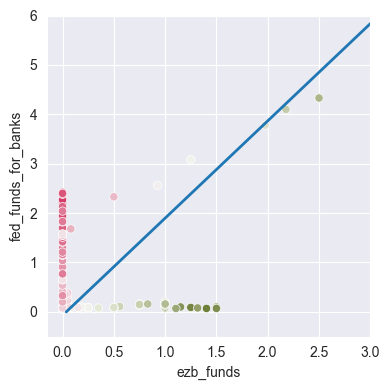

In [44]:
# Use scalings and center of means to determine decision boundary
center = np.mean(etf_lda.means_, axis=0)
print(center)
slope = - etf_lda.scalings_[0] / etf_lda.scalings_[1]
intercept = center[1] - center[0] * slope

x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([multiple_regression_combined_data_without_stabil, pred['positiv']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='ezb_funds', y='fed_funds_for_banks',
                    hue='positiv', data=lda_df,
                    palette=sns.diverging_palette(1, 100, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(-0.5, 6)
ax.set_xlim(-0.15, 3)
ax.plot((x_0, x_20), (0, 20), linewidth=2)

plt.tight_layout()
plt.show()

## Evaluierung Lineare Diskriminanzanalyse
### Confusion Matrix, Relevanz, Sensitivität (21, 22, 23)

In [45]:
# Confusion matrix
pred = etf_lda.predict(X)
pred_y = etf_lda.predict(X) == 'positiv'
true_y = y == 'positiv'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = negativ', 'Y = positiv'],
                       columns=['Yhat = negativ', 'Yhat = positiv'])
print(conf_mat)

             Yhat = negativ  Yhat = positiv
Y = negativ             107               0
Y = positiv              53               0


In [47]:
classificationSummary(y, etf_lda.predict(X),
                      class_names=etf_lda.classes_)

Confusion Matrix (Accuracy 0.6687)

        Prediction
 Actual negativ positiv
negativ       0      53
positiv       0     107


In [48]:
conf_mat = confusion_matrix(y, etf_lda.predict(X))

# Precision berechnen
precision = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[1, 0]) if (conf_mat[0, 0] + conf_mat[1, 0]) != 0 else 0
print('Precision:', precision)

# Recall berechnen
recall = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1]) if (conf_mat[0, 0] + conf_mat[0, 1]) != 0 else 0
print('Recall:', recall)

# Specificity berechnen
specificity = conf_mat[1, 1] / (conf_mat[1, 0] + conf_mat[1, 1]) if (conf_mat[1, 0] + conf_mat[1, 1]) != 0 else 0
print('Specificity:', specificity)


Precision: 0
Recall: 0.0
Specificity: 1.0


In [49]:
precision, recall, fscore, support = precision_recall_fscore_support(y, etf_lda.predict(X),
                                                                     labels=['negativ', 'positiv'],
                                                                     zero_division=0)

print('Precision:', precision)
print('Recall:', recall)
print('F-Score:', fscore)
print('Support:', support)

Precision: [0.      0.66875]
Recall: [0. 1.]
F-Score: [0.         0.80149813]
Support: [ 53 107]


## Naiver Bayes (18)

In [50]:
from sklearn.model_selection import train_test_split

multiple_regression_combined_data = pd.read_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

multiple_regression_combined_data['Comparison'] = multiple_regression_combined_data['Monthly Return'].apply(
    lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

multiple_regression_combined_data.to_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return_comparison.csv')

multiple_regression_combined_data_without_stabil = multiple_regression_combined_data[
    multiple_regression_combined_data['Comparison'] != 'stabil']

predictors = ['ezb_funds', 'fed_funds_for_banks']
outcome = 'Comparison'

# Datensatz für X und y definieren
X = multiple_regression_combined_data_without_stabil[predictors]
y = multiple_regression_combined_data_without_stabil[outcome]

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Klassifikator erstellen und trainieren
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten machen
y_pred = naive_model.predict(X_test)

# Genauigkeit der Vorhersagen auswerten
accuracy = accuracy_score(y_test, y_pred)

cl = pd.get_dummies(multiple_regression_combined_data_without_stabil.loc[146:146, predictors])
print('predicted class: ', naive_model.predict(cl)[0])
print('predicted probabilities', )
probabilities = pd.DataFrame(naive_model.predict_proba(cl), columns=naive_model.classes_)
print(probabilities)

predicted class:  negativ
predicted probabilities
    negativ   positiv
0  0.501568  0.498432


# Evaluierung Naiver Bayes
## Confusion Matrix, Relevanz, Sensitivität (21, 22, 23)

### Legende:
Y = positiv: Dies ist die tatsächliche Klasse "positiv".
Y = negativ: Dies ist die tatsächliche Klasse "negativ".
Yhat = positiv: Dies sind die Vorhersagen des Modells, bei denen die Klasse als "positiv" vorhergesagt wurde.
Yhat = negativ: Dies sind die Vorhersagen des Modells, bei denen die Klasse als "negativ" vorhergesagt wurde.

In [51]:
# Confusion matrix
pred = naive_model.predict(X)
pred_y = naive_model.predict(X) == 'positiv'
true_y = y == 'positiv'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = positiv', 'Y = negativ'],
                       columns=['Yhat = positiv', 'Yhat = negativ'])
print(conf_mat)

             Yhat = positiv  Yhat = negativ
Y = positiv              46              61
Y = negativ              17              36


### Ergebnisanalyse
True Positive (TP): Die Anzahl der Fälle, in denen das Modell richtig vorhergesagt hat, dass die Klasse "positiv" ist. In diesem Fall sind es 8 Fälle.
False Negative (FN): Die Anzahl der Fälle, in denen das Modell fälschlicherweise vorhergesagt hat, dass die Klasse "negativ" ist, obwohl sie tatsächlich "positiv" ist. In diesem Fall sind es 99 Fälle.
False Positive (FP): Die Anzahl der Fälle, in denen das Modell fälschlicherweise vorhergesagt hat, dass die Klasse "positiv" ist, obwohl sie tatsächlich "negativ" ist. In diesem Fall sind es 0 Fälle.
True Negative (TN): Die Anzahl der Fälle, in denen das Modell richtig vorhergesagt hat, dass die Klasse "negativ" ist. In diesem Fall sind es 55 Fälle.

In [53]:
classificationSummary(y, naive_model.predict(X),
                      class_names=naive_model.classes_)

Confusion Matrix (Accuracy 0.5125)

        Prediction
 Actual negativ positiv
negativ      36      17
positiv      61      46


In [54]:
conf_mat = confusion_matrix(y, naive_model.predict(X))

# Precision berechnen
precision = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[1, 0]) if (conf_mat[0, 0] + conf_mat[1, 0]) != 0 else 0
print('Precision:', precision)

# Recall berechnen
recall = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1]) if (conf_mat[0, 0] + conf_mat[0, 1]) != 0 else 0
print('Recall:', recall)

# Specificity berechnen
specificity = conf_mat[1, 1] / (conf_mat[1, 0] + conf_mat[1, 1]) if (conf_mat[1, 0] + conf_mat[1, 1]) != 0 else 0
print('Specificity:', specificity)


Precision: 0.3711340206185567
Recall: 0.6792452830188679
Specificity: 0.42990654205607476


### Precision, Recall, and Specificity of Naive Bayes Modell

In [55]:
precision, recall, fscore, support = precision_recall_fscore_support(y, naive_model.predict(X),
                                                                     labels=['negativ', 'positiv'],
                                                                     zero_division=0)

print('Precision:', precision)
print('Recall:', recall)
print('F-Score:', fscore)
print('Support:', support)

Precision: [0.37113402 0.73015873]
Recall: [0.67924528 0.42990654]
F-Score: [0.48       0.54117647]
Support: [ 53 107]


## Logistische Regression (20)

In [56]:
hpi_data = pd.read_csv('data/HPI_EZB.csv')


hpi_data['Period'].rename('Date')
hpi_data.columns = hpi_data.columns.str.replace('Percentage change', 'hpi_percentage_change_monthly')

# print(hpi_data)
# Transformation Period 2023Jun zu 2023-06-01
hpi_data['Date'] = pd.to_datetime(hpi_data["Period"], format="%Y%b").dt.strftime("%Y-%m-%d")

# Berechnung prozentuale Änderungen zum Vortag und fülle null Zeilen mit 0
# Speicherung des Wertes in die Spalte Change
hpi_data['Change'] = hpi_data['hpi_percentage_change_monthly'].diff().fillna(0)

# Vergleiche prozentuale Änderungen zum Vortag
# größer = positiv
# kleiner = negativ
# gleich = stabil
# Speicherung des Wertes in die Spalte Comparison
hpi_data['Comparison'] = hpi_data['Change'].apply(lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

hpi_data.to_csv(r'data/generatedDatasets/HPI_EZB_Change_Comparison.csv')

hpi_data = hpi_data.loc[(hpi_data["Date"] >= '2009-10-01') & (hpi_data["Date"] <= '2023-04-01'), ['Date','hpi_percentage_change_monthly']]

# print(hpi_data.head())

etf_multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data_with_return_comparison.csv')

etf_multiple_regression_combined_data = etf_multiple_regression_combined_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

etf_multiple_regression_combined_data.rename(columns={'Comparison': 'Monthly Return Comparison'}, inplace=True)

etf_table_with_hpi_monthly = pd.merge(hpi_data, etf_multiple_regression_combined_data, on='Date', how='inner')


etf_table_with_hpi_monthly.to_csv('data/generatedDatasets/etf_table_with_hpi_monthly.csv')


In [71]:
from sklearn.linear_model import LogisticRegression

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_customer', 'hpi_percentage_change_monthly']
outcome = 'Monthly Return Comparison'

etf_table_with_hpi_monthly_data = pd.read_csv('data/generatedDatasets/etf_table_with_hpi_monthly.csv')

etf_table_with_hpi_monthly_data_without_stabil = etf_table_with_hpi_monthly_data[etf_table_with_hpi_monthly_data['Monthly Return Comparison'] != 'stabil']

X = pd.get_dummies(etf_table_with_hpi_monthly_data_without_stabil[predictors], prefix='', prefix_sep='',
                   drop_first=True)
y = etf_table_with_hpi_monthly_data_without_stabil[outcome]

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]},
             index=X.columns)

intercept  3.3491330671307993
classes ['negativ' 'positiv']


,coeff
ezb_funds,0.336359
fed_funds_for_banks,0.908847
fed_funds_for_customer,-0.792358
hpi_percentage_change_monthly,-0.190698


In [73]:
predicted_classes = logit_reg.predict(X)

# Wandele die predicted_classes und die unabhängigen Variablen in DataFrames um
predictions_df = pd.DataFrame(predicted_classes, columns=['Predicted Class'])
independent_vars_df = pd.DataFrame(X, columns=predictors)

# Füge die beiden DataFrames zusammen
result_df = pd.concat([predictions_df, independent_vars_df], axis=1)


result_df.to_csv("data/generatedDatasets/logReg.csv")

# Drucke die resultierende Tabelle
print(result_df)

    Predicted Class  ezb_funds  fed_funds_for_banks  fed_funds_for_customer  \
0           positiv   3.161290                 4.65                    7.75   
1           positiv   2.875000                 4.57                    7.50   
2           positiv   2.500000                 4.33                    7.50   
3           positiv   2.177419                 4.10                    7.00   
4           positiv   1.975000                 3.78                    6.25   
..              ...        ...                  ...                     ...   
156         positiv   1.000000                 0.16                    3.25   
157         positiv   1.000000                 0.13                    3.25   
158         positiv   1.000000                 0.11                    3.25   
159         positiv   1.000000                 0.12                    3.25   
160             NaN   1.000000                 0.12                    3.25   

     hpi_percentage_change_monthly  
0             

In [74]:
# Zähle die Anzahl der Vorkommen jeder Klasse
class_counts = predictions_df['Predicted Class'].value_counts()

# Drucke die Zusammenfassung
print(class_counts)

Predicted Class
positiv    148
negativ     12
Name: count, dtype: int64


In [58]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

          negativ     positiv
count  160.000000  160.000000
mean    -1.126833   -0.411497
std      0.196588    0.144656
min     -1.449482   -1.010442
25%     -1.242367   -0.396978
50%     -1.172407   -0.370514
75%     -1.115805   -0.340661
max     -0.452648   -0.267477


In [59]:
# use GLM (general linear model) with the binomial family to
# fit a logistic regression
y_numbers = [1 if yi == 'positiv' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  160
Model:                            GLM   Df Residuals:                      155
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.431
Date:                Thu, 13 Jul 2023   Deviance:                       198.86
Time:                        00:31:35   Pearson chi2:                     160.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02686
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
ezb_funds     

In [60]:
# use GLM (general linear model) with the binomial family to
# fit a logistic regression
y_numbers = [1 if yi == 'negativ' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  160
Model:                            GLM   Df Residuals:                      155
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.431
Date:                Thu, 13 Jul 2023   Deviance:                       198.86
Time:                        00:31:35   Pearson chi2:                     160.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02686
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
ezb_funds     

In [61]:
import statsmodels.formula.api as smf

etf_table_with_hpi_monthly_data = etf_table_with_hpi_monthly_data[etf_table_with_hpi_monthly_data['Monthly Return Comparison'] != 'stabil']

target_value = etf_table_with_hpi_monthly_data['Monthly Return Comparison']


etf_table_with_hpi_monthly_data.drop('Monthly Return Comparison', axis=1, inplace=True)



formula = 'target_value ~ ezb_funds + bs(fed_funds_for_banks, df=8) + fed_funds_for_customer  + hpi_percentage_change_monthly'
model = smf.glm(formula=formula, data=etf_table_with_hpi_monthly_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     ['target_value[negativ]', 'target_value[positiv]']   No. Observations:                  160
Model:                                                            GLM   Df Residuals:                      148
Model Family:                                                Binomial   Df Model:                           11
Link Function:                                                  Logit   Scale:                          1.0000
Method:                                                          IRLS   Log-Likelihood:                -95.322
Date:                                                Thu, 13 Jul 2023   Deviance:                       190.64
Time:                                                        00:31:35   Pearson chi2:                     160.
No. Iterations:                                                     5   Pseudo R-squ. (CS):            0.07558
C

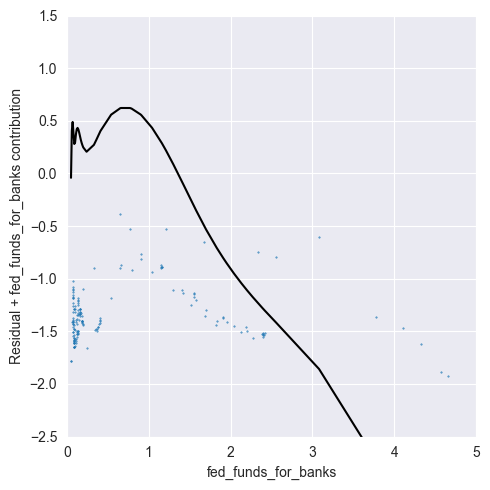

In [62]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, etf_table_with_hpi_monthly, 'Monthly Return Comparison', 'fed_funds_for_banks', fig, ax)
ax.set_xlim(0, 5)
ax.set_ylim(-2.5, 1.5)


plt.tight_layout()
plt.show()